#  Generative Tasks and Latent Space Exploration with Variational Autoencoders                 

Variational Autoencoders most known applications are Generative Modeling and their ability to learn latent representations about data. In this notebook we will use the MNIST dataset to demonstrate that. Firstly, we will train a VAE on the MNIST training set. Once trained, because of the unsupervised and statistical nature of the VAE, we will be able to use the same model for different tasks.

First we load some libraries and dependencies:

In [1]:
import sys 
import os 

sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from torch import optim
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from src.model import VAE
from src.configs import mnist_configs
from src.train import train
from src.utils import latent_visualization, print_manifold

#### TRAINING THE VAE

I am have a Nvidia GPU so I will be using cuda for training the model. However, this dataset is simple enough to be trained and loaded using a CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


We will apply two transformations to MNIST data:

- `ToTensor()` will convert the MNIST images to tensor format. The tensor values will be in the interval $[0, 1]$.
- `Lambda(lambda x: x.view(-1))` is a simple personalized transform method to flatten input tensors. The VAE I implemented is composed of dense layers rather than convolutional layers, consequently the model expects one dimensional vectors per datapoint (image).

Then we will define the MNIST training set using `torch.utils.data.datasets`, which contains many famous Deep Learning datasets. For it to be downloaded automatically you just need to specify the argument `download = True`. 

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)) # Flat input
])

mnist = datasets.MNIST(root= r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data",
                       download = False,
                       train = True,
                       transform = transform)

Then, we build the train_loader using the `torch.utils.data.DataLoader` class with a batch size of 128 images. 

In [5]:
train_loader = DataLoader(mnist,
                          batch_size=128,
                          shuffle=True,
                          pin_memory=True, # This will improve loading and training
                          drop_last=True # Last batch will be dropped if its size is not 64
                          )

Our next step is to define the model. For the last layer we will use the sigmoid activation function because the tensors' entries have values in $[0, 1]$. After some tuning I have decided to set $\alpha = 3 \cdot 10^{-4}$ and two hidden layer with dimensions 512 and 256. Due to latent space visualization purposes, the latent dimension was always 2 during this phase. The model was trained in $50$ epochs. 

Although the MNIST dataset contains $60000$ images in its training set, these are simple $28 \times 28$ black and white images of hand written digits. Because of this we must be careful enough to implement a training procedure that does not ignore the latent space and overfits training data without learning anything significant. 

In [6]:
model = VAE(**mnist_configs, f_out = 'sigmoid')

In [7]:
optimizer = optim.Adam(model.parameters(), lr= 3e-4)

train(model,train_loader,optimizer,device, max_beta = 4, epochs=50, f_out='sigmoid', labels=True)

Epoch 1 -----> -ELBO: 196.18249410807292 | KL: 2769.620361328125 | Reconstruction Error: 20905.75
Epoch 2 -----> -ELBO: 162.55334547526041 | KL: 1706.38623046875 | Reconstruction Error: 20652.34765625
Epoch 3 -----> -ELBO: 156.30141790364584 | KL: 1385.18115234375 | Reconstruction Error: 18652.208984375
Epoch 4 -----> -ELBO: 153.42333873697916 | KL: 1168.9991455078125 | Reconstruction Error: 19218.955078125
Epoch 5 -----> -ELBO: 151.27298564453125 | KL: 1179.336669921875 | Reconstruction Error: 18508.876953125
Epoch 6 -----> -ELBO: 149.74132779947917 | KL: 1039.90185546875 | Reconstruction Error: 18065.7578125
Epoch 7 -----> -ELBO: 148.593352734375 | KL: 979.2937622070312 | Reconstruction Error: 18231.16015625
Epoch 8 -----> -ELBO: 147.71926516927084 | KL: 910.5516967773438 | Reconstruction Error: 18723.119140625
Epoch 9 -----> -ELBO: 147.11582552083334 | KL: 911.2058715820312 | Reconstruction Error: 18251.33984375
Epoch 10 -----> -ELBO: 146.61143271484374 | KL: 859.0059814453125 | Rec

The training lasted 4 minutes and 2 seconds

#### LATENT SPACE VISUALIZATION

We perform the same operation that we previously did in order to load the test data.

In [8]:
mnist_test = datasets.MNIST(root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data",
                            download=False,
                            train=False,
                            transform=transform)

test_loader = DataLoader(mnist_test,
                         batch_size=64,
                         shuffle=False,
                         pin_memory=True,
                         drop_last=False)

Now we set our model in evaluation mode and with `torch.no_grad()` activated we iterate over the images and labels contained in the test set while at the same time we pass them through the VAE encoder. By doing so we get each image latent $\mu$ and we append both latent points and labels in a python list. Finally, we use `torch.cat()` to get a tensor (in reality a usual matrix) with all the $\mu$ and labels stacked vertically.

Notice that we have not used $\log \sigma^2$, that is because for representation purposes we prefer to avoid the randomness the whole reparametrization trick introduces. Sampling $\mu$ for each image and visualizing it will be just enough to get an idea of how the latent space is structured and if our model has done well. 

In [9]:
model.eval()
z = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, _ = model.encoder(x)
        z.append(mu.cpu()) 
        labels.append(y)

z = torch.cat(z)
labels = torch.cat(labels)

Using `latent_visualization` and `seaborn` we are finally able to visualize the latent space in $\mathbb{R}^2$.

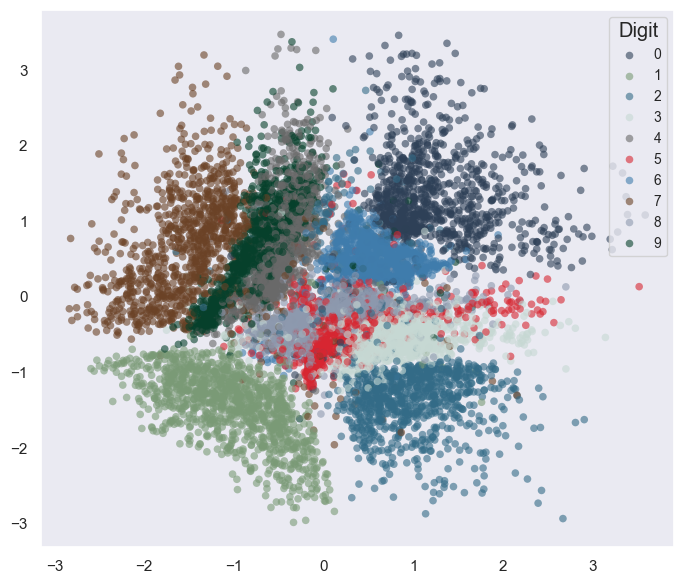

In [10]:
latent_visualization(z, labels, download = True)

In [11]:
plt.rcdefaults() # Resets the Matplotlib settings to avoid unexpected results in the next plots

As we can see the VAE did a great job to learn a 2-D representation for 0 to 9 digits written in $28 \times 28$ pixels images. The most identifiable digits have the best defined regions while there are smooth and continous transitions between digits which share some patterns like 5 and 6 for example.

#### GENERATIVE MODELING

The transitions will be more clear in the next image where we will represent new digits, generated from latent space points contained in a grid. Where two digits regions collides begins the continuous transformation from one into the other. This is achieved thanks to the VAE continous variational density $q (z | x)$ assumption, in this case a multivariate factorized Gaussian distribution.

In `src/utils.py` you can see how the `print_manifold` function was defined.

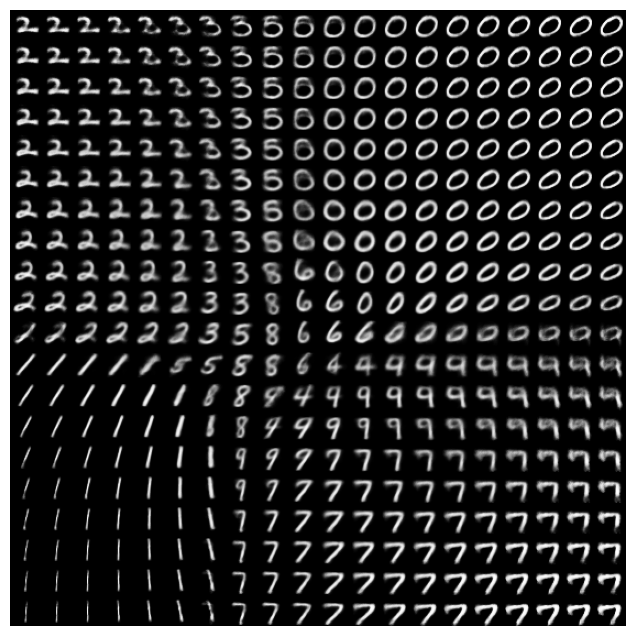

In [12]:
print_manifold(model, device, download = True)

#### DENOISING AND DATA IMPUTATION

Standard Autoencoders are known to be useful for noise reduction, they minimize a reconstruction loss which forces the model to reconstruct corrupted images into original images with no noise. The main disadvantage is that you need to train the model with both corrupted versions and original images in order to compute the loss and achieve the task desired.

In contrast with this, VAEs are sometimes capable of reconstructing images with certain noise or missing parts without the necessity to train the model with corrupted versions, this is due to the latent space distribution . We are going to prove this is possible using the MNIST dataset and the already trained model. 

We will create two functions:

- `add_gaussian_noise` 

- `salt_and_pepper` which adds salt and pepper noise. Our images have $28 \times 28$ resolution so adding this type of noise will be like deleting some parts of the image

In [13]:
def add_gaussian_noise(tensor, eps = 0.1):
    return tensor + torch.randn_like(tensor)*eps

In [14]:
from skimage.util import random_noise

def salt_and_pepper(x, amount):
    x = x.cpu().numpy()
    x = random_noise(x, mode='s&p', amount = amount)
    x = torch.tensor(x, dtype=torch.float32)
    return x

First we load the data with Gaussian Noise

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    transforms.Lambda(lambda x:add_gaussian_noise(x))
])

mnist_noise = datasets.MNIST(root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data",
                            download=False,
                            train=False,
                            transform=transform)

noise_loader = DataLoader(mnist_noise,
                         batch_size=64,
                         shuffle=False,
                         pin_memory=True,
                         drop_last=False)

Now we get a test example and transform it to a `NumPy` matrix.

In [32]:
iterator = iter(noise_loader)

In [33]:
data, _ = next(iterator)

x = data[0].to(device)

corrupted_img = x.cpu().numpy()
corrupted_img = corrupted_img.reshape(28,28)

After that we pass its tensor through the VAE and we see the corrupted vs reconstructed image.

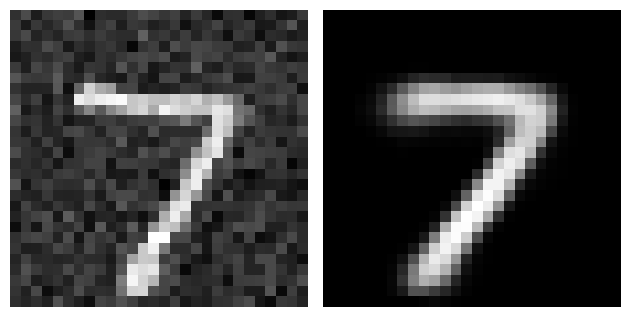

In [35]:
x_hat, _, _ = model(x)

with torch.no_grad():
    reconstruction_img = x_hat.cpu().numpy().reshape(28, 28)

plt.subplots(nrows = 1, ncols = 2)

plt.subplot(1, 2, 1)
plt.imshow(corrupted_img, cmap='gray')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(reconstruction_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

We do the exact same operation with the salt and pepper noise.

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    transforms.Lambda(lambda x:salt_and_pepper(x, amount = 0.15))
])

mnist_noise = datasets.MNIST(root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data",
                            download=False,
                            train=False,
                            transform=transform)

noise_loader = DataLoader(mnist_noise,
                         batch_size=64,
                         shuffle=False,
                         pin_memory=True,
                         drop_last=False)

In [23]:
iterator = iter(noise_loader)

In [28]:
data, _ = next(iterator)

x = data[0].to(device)

corrupted_img = x.cpu().numpy()
corrupted_img = corrupted_img.reshape(28,28)

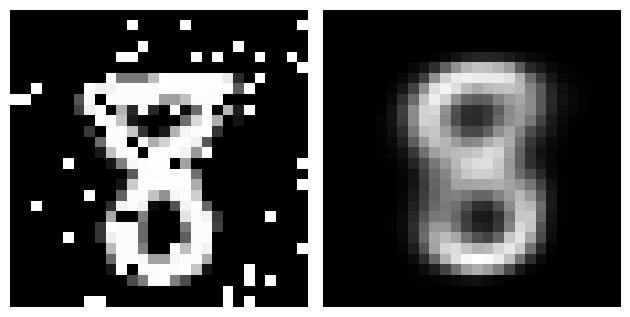

In [30]:
x_hat, _, _ = model(x)

with torch.no_grad():
    reconstruction_img = x_hat.cpu().numpy().reshape(28, 28)


plt.subplots(nrows = 1, ncols = 2)

plt.subplot(1, 2, 1)
plt.imshow(corrupted_img, cmap='gray')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(reconstruction_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()